In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
###### LOAD ANALYZER OUTPUT #####

fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/MC_Summer16/v11/v5/'
bkg_path = path+"/bkg/wH/normalized/"
# greater than one lepton, lepton 27 GeV cut, greater than 2 jets
lumi = 137000 #in pb-1

fpath_bkg['WJetsToLNu'] = bkg_path+"WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root"
start_t = time.time()
if wH:
    sig_path = path+'signals/wH/normalized/'
else:    
    sig_path = path+'/signals/zH/normalized/'
fpath_bkg['bbbb10m'] = sig_path + 'WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'
fpath_bkg['bbbb1m'] = sig_path + 'WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-1000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'
# fpath_bkg['bbbb0.1m'] = sig_path + 'WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-100_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'


NEvents = {}

for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
#     if k[:7] == 'ntuples':
#         tree_bkg[k] = root_dir['ntuples']['llp']
#         NEvents[k] = root_dir['ntuples']['NEvents'][1]
#     else:
    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["weight"].array()
    print ('weights',np.unique(a)*lumi)
#     print(len(a)/ NEvents[k])
#     print(a.shape)
print(time.time()-start_t)



WJetsToLNu /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/MC_Summer16/v11/v5//bkg/wH/normalized/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root
weights [-48.58789046  48.58789046]
bbbb10m /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/MC_Summer16/v11/v5/signals/wH/normalized/WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root
weights [-1.58039884 -1.00285431  1.00285431  1.58039884]
bbbb1m /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/MC_Summer16/v11/v5/signals/wH/normalized/WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-1000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root
weights [-1.58415991 -1.00145274  1.00145274  1.58415991]
2.615769386291504


In [3]:
trigger_names_file = '/nfshome/christiw/llp/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
if wH:
    trigger_paths = [87,135] #PFMET120
else:
    trigger_paths = [177,362,87,135] #PFMET120

# 177 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
# 362 HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ
# 310 HLT_PFMET120_PFMHT120_IDTight
# 87 HLT_Ele32_WPTight_Gsf
# 135 HLT_IsoMu24
# 310 PFMET


In [4]:

legend = {}
legend['bbbb10m'] = 'signal c#tau = 10 m'
legend['bbbb1m'] = 'signal c#tau = 1 m'
legend['bbbb0.1m'] = 'signal c#tau = 0.1 m'

legend['SingleElectron'] = 'SingleElectron'
legend['SingleMuon'] = 'SingleMuon'
legend['WJetsToLNu'] = 'WJetsToLNu'

In [197]:
start_t = time.time()

weight = {}
trigger_decision = {}
gParticlePt = {}
nCsc = {}
pdgId = 11
for k,T in tree_bkg.items():
    
    
        
    #### select events that pass ID cut & gen level cut ####
    gParticleId = T.array('gLepId')
    sel_id = np.logical_and(np.abs(T.array('lepPdgId')) == pdgId, T.array('lepPassId'))
    sel_lep = np.logical_and(sel_id.sum() >= 1, np.abs(T.array('gLepId')) == pdgId)

    gParticlePt[k] = T.array('gLepPt')[sel_lep]
    weight[k] = T.array('weight')[sel_lep]*lumi
    nCsc[k] = T.array('nCsc')[sel_lep]
    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev= np.zeros(hlt[:,0].shape)
    for tr in trigger_paths:
        sel_ev  = np.logical_or(sel_ev,hlt[:,tr])

        
    trigger_decision[k] = weight[k]*sel_ev[sel_lep]
    print(k,np.sum(trigger_decision[k])/np.sum(weight[k]))
# #     print(k,np.sum(weight[k])/(xsec[k]*lumi))
# #     nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] =T.array('nCsc_JetMuonVetoCluster0p4_Me1112Veto')    
    
#     sel_ev = np.logical_and(sel_ev, np.abs(T.array('lepGenId')) == 13)
#     sel_ev = np.logical_and(sel_ev, T.array('nLeptons') == 1)
# #     sel_ev = np.logical_and(sel_ev, np.abs(T.array('lepPdgId')) == 13)
#     weight_trigger[k] = weight[k]*sel_ev
#     print(k, np.count_nonzero(sel_ev)/len(sel_ev))


#     nJets[k] =T.array('nJets')
#     cscTime[k] = T.array('cscT')
#     npu[k] = T.array('npu')
#     npv[k] = T.array('npv')


#     cscTime[k] = np.array([np.mean(a) if len(a)>0 else 0 for a in cscTime[k]])

print(time.time()-start_t)

WJetsToLNu 0.4408341496621229
bbbb10m 0.5949785134321481
bbbb1m 0.6128104412359747
bbbb0.1m 0.6813338359660868
6.024562835693359


(581027,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


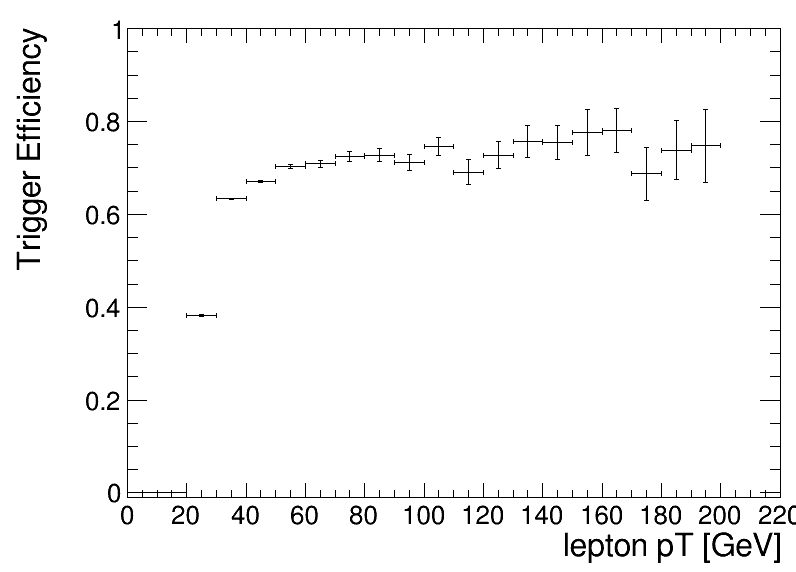

In [186]:
c = rt.TCanvas('c','c', 800, 600)
h = {}
leg = rt.TLegend(0.7,0.70,0.9,0.9);
leg.SetTextSize(0.03)

k = 'WJetsToLNu'
xaxis = gParticlePt[k]
xaxis_title = 'lepton pT [GeV]'
bins = [20,0,200]

# xaxis = nCsc[k]
# xaxis_title = 'nCsc'
# bins = [30,0,300]

print(xaxis.shape)
hm = create_TH1D(xaxis, 'hm1', axis_title = [xaxis_title,'Trigger Efficiency'], binning=bins,weights = trigger_decision[k])
hb = create_TH1D(xaxis, 'hb1', axis_title = [xaxis_title,'Trigger Efficiency'], binning=bins,weights = weight[k])
pEff1 = rt.TEfficiency(hm,hb)
pEff1.SetLineColor(std_color_list[0])
pEff1.Draw()

# xaxis = ele2_pt
# bins = [0,30,40,60,150]
# hm = create_TH1D(xaxis, 'hm2', axis_title = [xaxis_title,'Trigger Efficiency'], binning=bins,weights = trigger_decision['zee'][362])
# hb = create_TH1D(xaxis, 'hb2', axis_title = [xaxis_title,'Trigger Efficiency'], binning=bins)
# pEff2 = rt.TEfficiency(hm,hb)
# pEff1.SetLineColor(std_color_list[1])
# pEff2.Draw('same')
# leg.AddEntry(pEff1,'Electron1 pT')
# leg.AddEntry(pEff2,'Electron2 pT')

# hb.Draw()
# hb.Draw()
# hm.Draw('same')
# leg.Draw()
# c.SetLogy()
c.Draw()
pEff1.GetPaintedGraph().GetYaxis().SetRangeUser(-0.01,1)

# c.SaveAs("../../plots/trigger_efficiency/zh_trigger362_elept.pdf")

# Offline Selection

In [195]:
start_t = time.time()

weight = {}
id_efficiency = {}
gLepPt = {}
gLepEta = {}
pdgId = 13
for k,T in tree_bkg.items():
    
    
    #### select triggered muon events #####
#     hlt = T['HLTDecision'].array()
#     sel_ev= np.zeros(hlt[:,0].shape)
#     for tr in trigger_paths:
#         sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
    sel_ev = T.array('gLepId') == pdgId
#     sel_ev = np.logical_and(sel_ev,np.abs(T.array('gLepEta')) < 2.4)
#     sel_ev = np.logical_and(sel_ev,np.abs(T.array('gLepPt')) < 2.4)


    weight[k] = T.array('weight')[sel_ev]*lumi
    gLepPt[k] = T.array('gLepPt')[sel_ev]
    gLepEta[k] = T.array('gLepEta')[sel_ev]


    #### select events that pass ID cut ####
    sel_id = np.logical_and(np.abs(T.array('lepPdgId')) == pdgId, T.array('lepPassId'))
    sel_id = sel_id.sum() >= 1
    
    
    id_efficiency[k] = weight[k]*sel_id[sel_ev]
    print(k,np.count_nonzero(id_efficiency[k])/np.count_nonzero(weight[k]))


print(time.time()-start_t)

WJetsToLNu 0.9403269928112475
bbbb10m 0.9033149171270718
bbbb1m 0.871866295264624
bbbb0.1m 0.9421965317919075
1.0084547996520996


(99628,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


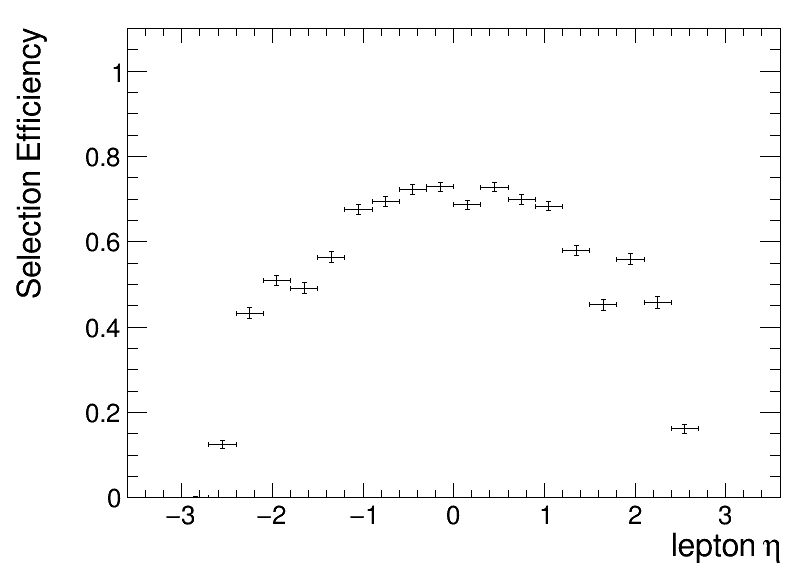

In [194]:
c = rt.TCanvas('c','c', 800, 600)
h = {}
leg = rt.TLegend(0.7,0.70,0.9,0.9);
leg.SetTextSize(0.03)

k = 'WJetsToLNu'
xaxis = gLepPt[k]
xaxis_title = 'lepton pT [GeV]'
bins = [50,0,300]

xaxis = gLepEta[k]
# print(gLepEta[k][gLepEta[k]>2.1])
# print(id_efficiency[k][gLepEta[k]>2.1])


xaxis_title = 'lepton #eta'
bins = [20,-3,3]

print(xaxis.shape)
hm = create_TH1D(xaxis, 'hm1', axis_title = [xaxis_title,'Selection Efficiency'], binning=bins,weights = id_efficiency[k])
hb = create_TH1D(xaxis, 'hb1', axis_title = [xaxis_title,'Selection Efficiency'], binning=bins,weights = weight[k])
pEff1 = rt.TEfficiency(hm,hb)
pEff1.SetLineColor(std_color_list[0])

pEff1.Draw()

# xaxis = ele2_pt
# bins = [0,30,40,60,150]
# hm = create_TH1D(xaxis, 'hm2', axis_title = [xaxis_title,'Trigger Efficiency'], binning=bins,weights = trigger_decision['zee'][362])
# hb = create_TH1D(xaxis, 'hb2', axis_title = [xaxis_title,'Trigger Efficiency'], binning=bins)
# pEff2 = rt.TEfficiency(hm,hb)
# pEff1.SetLineColor(std_color_list[1])
# pEff2.Draw('same')
# leg.AddEntry(pEff1,'Electron1 pT')
# leg.AddEntry(pEff2,'Electron2 pT')

# hb.Draw()
# hb.Draw()
# hm.Draw('same')
# leg.Draw()
# c.SetLogy()
c.Draw()
pEff1.GetPaintedGraph().GetYaxis().SetRangeUser(0.0,1.1)

# c.SaveAs("../../plots/trigger_efficiency/zh_trigger362_elept.pdf")

# Acceptance

In [39]:
gLLP_eta = {}
gLLP_r = {}
gLLP_z = {}
weight = {}
for k,T in tree_bkg.items():
    gLLP_eta[k] = T.array('gLLP_eta')
    gLLP_r[k] = T.array('gLLP_decay_vertex_r')
    gLLP_z[k] = T.array('gLLP_decay_vertex_z')
#     sel_llp = np.logical_and(np.abs(gLLP_eta[k])<2.4, np.abs(gLLP_eta[k])>0.9)
#     sel_llp = np.logical_and(sel_llp, np.abs(gLLP_z[k])<1100)
#     sel_llp = np.logical_and(sel_llp, np.abs(gLLP_z[k])>568)
#     sel_llp = np.logical_and(sel_llp,gLLP_r[k] < 695.5)
#     sel_llp = np.sum(sel_llp,axis=1) >= 1 #at least 1 llp in csc system
    weight[k] = np.column_stack((T.array('weight'), T.array('weight')))*lumi
#     weight[k] = T.array('weight')*lumi
#     print(k,np.count_nonzero(sel_llp)/len(sel_llp))
#     print(k,np.sum(weight[k][sel_llp])/np.sum(weight[k]))
#     print(k,np.sum(weight[k][sel_llp]))



0.0036344528198242188


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


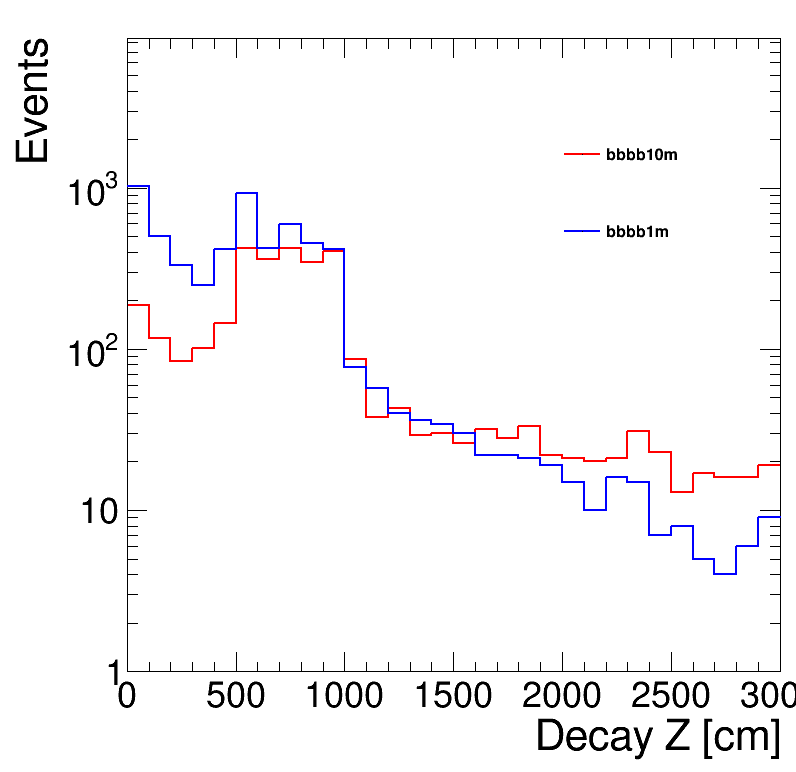

In [40]:
# output_root = rt.TFile("output.root","RECREATE")

start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.70,0.65,0.95,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}




max_y = 0
i =0 
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
bkg_nCsc = []
for k in tree_bkg.keys():
    w = weight[k].flatten()
 
    h[k] = create_TH1D( gLLP_z[k].flatten(), axis_title=['Decay Z [cm]', 'Events'], name=k, binning=[30,0,3000])
#     h[k] = create_TH1D( gLLP_eta[k].flatten(), axis_title=['gLLP #eta', 'Events'], name=k, binning=[30,-5,5])
#     h[k] = create_TH1D( gLLP_r[k].flatten(), axis_title=['Decay Radius [cm]', 'Events'], name=k, binning=[30,0,3000],weights = w)



    h[k].SetLineColor(std_color_list[i+1])
    currentMax=h[k].GetBinContent(h[k].GetMaximumBin())
    if currentMax > max_y:
        max_y = currentMax
        h[k].SetMaximum(20*currentMax)
        h[k].SetMinimum(1)
    h[k].Draw("same hist")
    i+=1

    leg.AddEntry(h[k],k)

leg.Draw()
c.SetLogy()
c.Draw()

print(time.time()-start_t)




# jetveto efficiency

In [5]:
start_t = time.time()
pdgId = 13
JET_PT_CUT = 10
MUON_PT_CUT = 20


weight = {}
weight_event = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}

selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
for k,T in tree_bkg.items():

    ###### OOT control region #####
     
    
#     sel_cluster = np.logical_and( sel_cluster, T.array('cscClusterMe1112Ratio') < 0.01)
    sel_cluster[k] = T.array('cscClusterMaxLayerRatio')*T.array('cscClusterSize') > 5.01
    sel_cluster[k] = np.logical_and( sel_cluster[k], T.array('cscClusterTime') > -12.5)
    sel_cluster[k] = np.logical_and( sel_cluster[k], T.array('cscClusterTime') < 22) 
#     sel_cluster[k] = np.logical_and( sel_cluster[k], T.array('cscClusterMe1112Ratio') < 0.01)


#     sel_cluster[k] = np.logical_and( sel_cluster[k],T.array('cscClusterJetVeto') < JET_PT_CUT)
#     sel_cluster[k] = np.logical_and( sel_cluster[k], T.array('cscClusterMuonVeto') < MUON_PT_CUT)
#     sel_cluster[k] = np.logical_and(sel_cluster[k], T.array('cscClusterTime') < -12.5)
#     sel_cluster[k] = np.logical_and(sel_cluster[k], T.array('cscClusterTime') > -62.5)
########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
    sel_ev= np.zeros(hlt[:,0].shape)
    for tr in trigger_paths:            
        sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
    sel_muon = np.logical_and(T.array('lepPassId'), T.array('lepPt')>=25)
    sel_muon = np.logical_and(sel_muon, np.abs(T.array('lepEta'))<2.4)
    sel_muon = np.logical_and(sel_muon, np.abs(T.array('lepPdgId')) == 13)

    sel_ele = np.logical_and(T.array('lepPassId'), T.array('lepPt')>=35)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepEta'))<2.4)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepPdgId')) == 11)
    
    sel_lep = np.logical_or(sel_ele, sel_muon)
    sel_ev = np.logical_and(sel_ev, sel_lep.sum() == 1)
    sel_jetveto[k] = sel_ev

    ##### event variables #####
    weight[k] = sel_cluster[k]*0.0 + T.array('weight')*lumi
    npv[k] = sel_cluster[k]*0.0 + T.array('npv')
    npu[k] = sel_cluster[k]*0.0 + T.array('npu')

print(time.time()-start_t)

9.043864011764526


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT

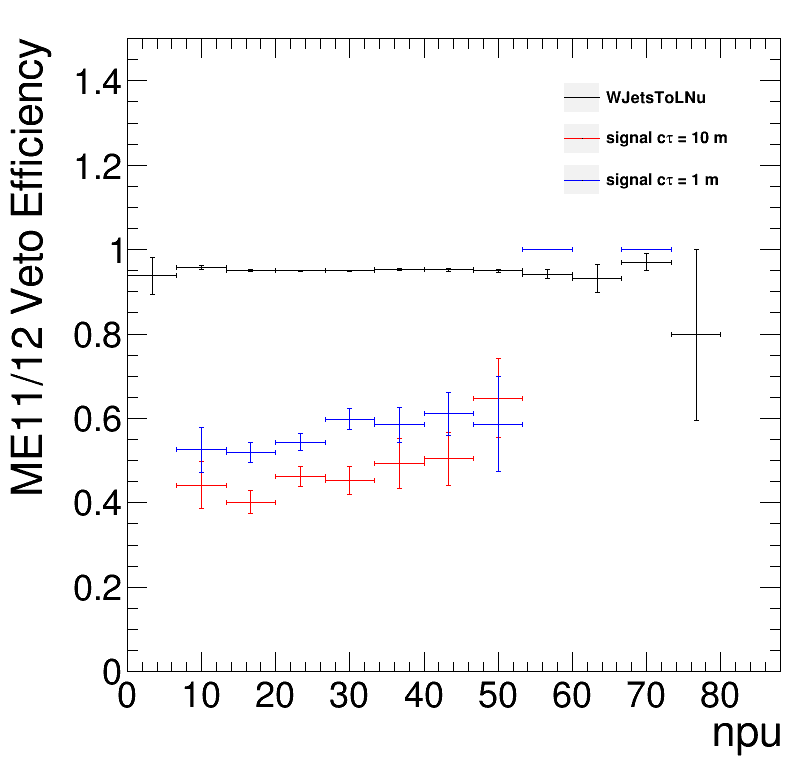

In [7]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()
leg = rt.TLegend(0.70,0.74,0.95,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
h = {}
rt.gStyle.SetOptFit(1011)
i = 0
for k,T in tree_bkg.items():
#     if not k == 'WJetsToLNu': continue
    bins = [15,0,100]
    yaxis_title = 'ME11/12 Veto Efficiency'
#     yaxis_title = 'Jet Veto Efficiency'


    hb = create_TH1D(npu[k][sel_cluster[k]][sel_jetveto[k]].flatten(), 'hb1', axis_title = ['npu',yaxis_title], binning=bins,weights = weight[k][sel_cluster[k]][sel_jetveto[k]].flatten())
#     hb = create_TH1D(npu[k][sel_cluster[k]][sel_jetveto[k]].flatten(), 'hb1', axis_title = ['npu',yaxis_title], binning=bins,weights = weight[k][sel_cluster[k]][sel_jetveto[k]].flatten())


#     cond = np.logical_and(sel_cluster[k], T.array('cscClusterJetVeto') > 30)
#     cond = np.logical_and(sel_cluster[k], T.array('cscClusterMuonVeto') > 20)
    cond = np.logical_and(sel_cluster[k],  T.array('cscClusterMe1112Ratio') > 0.01)

    

    hm = create_TH1D(npu[k][cond][sel_jetveto[k]].flatten(), 'hm1', axis_title = ['npu', yaxis_title], binning=bins,weights = weight[k][cond][sel_jetveto[k]].flatten())
    h[k] = rt.TEfficiency(hm,hb)  
    h[k].SetLineColor(std_color_list[i])
    
    leg.AddEntry(h[k], legend[k])
#     h[k].SetMinimum(1)
    h[k].Draw('' if i==0 else 'same')



    i+=1

# c = make_ratio_plot([h[mc],h[data]], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])
# c.SetRightMargin(0)
# c.SetLogy()

leg.Draw()
c.Draw()

h['WJetsToLNu'].GetPaintedGraph().GetYaxis().SetRangeUser(0.0,1.5)


    


# c.Draw()
# print(time.time()-start_t)

# nCsc histogram

# event yield vs. ncsc

# significance

# DBSCAN

# Time response in rechit cut

# Time response in ECAL energy bins

# Time response in t_gen